In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

2023-03-05 13:15:02.007265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 13:15:02.151816: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-05 13:15:02.613931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-05 13:15:02.613990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))


class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

train.shape = 94477 rows, 4 cols


In [3]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [4]:
def load_frames(
    frames_data,
    max_frames: int = 20,
    crop_method: str = 'nearest',
    get_masks: bool = True,
):
    '''Take frames data shape=(n_frames, pts, dims) to fixed num of frames.
    
    - Pads data with fewer frames with zeros
    - Reduces max number of allowed frames by crop method:
        * 'nearest' (default): 
    '''
    
    if len(frames_data) < max_frames:
        diff = max_frames - len(frames_data)
        padding = np.zeros((diff, 543, 3))
        frames = np.concatenate((frames_data, padding))
        if get_masks:
            # Only mask the padding
            masks = np.zeros(shape=(1, max_frames,), dtype='bool')
            masks[0,:len(frames_data)] = 1
            
    else:
        if crop_method == 'nearest':
            frames = tf.image.resize(
                frames_data,
                (max_frames, 543),
                method='nearest',
            ).numpy()
        elif crop_method == 'cut':
            frames = frames_data[:max_frames]
        else:
            raise Exception(f'{crop_method=} not found')
        if get_masks:
            # Use all the frames
            masks = np.ones(shape=(1, max_frames,), dtype='bool')

    if get_masks:
        return frames, masks
    else:
        return frames

In [5]:
def compress_frames(frames):
    '''Make a video of shape (n_frames, pts, dims) --> (n_frames, pts*dims) '''
    n_frames = frames.shape[0]
    columns = frames.shape[1]*frames.shape[2]
    return frames.reshape(n_frames, columns)

In [6]:
# Hyperparams
MAX_FRAMES = 20
MAX_SEQ_LENGTH = MAX_FRAMES
N_PTS = 543
N_DIMS = 3
NUM_FEATURES = N_PTS*N_DIMS

X_npy_fname = f'X-{MAX_FRAMES}_frames-pts_flattened.npy'
y_npy_fname = f'y.npy'
masks_fname = f'all_masks-{MAX_FRAMES}.npy'

if CFG.is_training:
    try:
        X = np.load(X_npy_fname)
        All_masks = np.load(masks_fname)
        y = np.load(y_npy_fname)
    except:
        X = np.zeros((len(train), MAX_FRAMES, N_PTS*N_DIMS))
        All_masks = np.zeros(shape=(len(train), MAX_FRAMES), dtype='bool')
        y = np.zeros((len(train),))
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            frames_reduced, masks = load_frames(data, max_frames=MAX_FRAMES)
            data_resize = compress_frames(frames_reduced)
            X[i] = data_resize
            All_masks[i] = masks
            y[i] = train.iloc[i].label
            num_frames[i] = data.shape[0]
        ## Save number of frames of each training sample for data analysis
        train['num_frames'] = num_frames
        print(train['num_frames'].describe())
        train.to_csv('train.csv', index=False)
        np.save(X_npy_fname, X)
        np.save(y_npy_fname, y)
        np.save(masks_fname, All_masks)

    print(X.shape, y.shape)

(94477, 20, 1629) (94477,)


In [7]:
# All_masks as part of split
X_train, X_val, M_train, M_val, y_train, y_val = train_test_split(
    X, All_masks, y,
    test_size=0.2,
    random_state=27,
    stratify=y,
)
print(X_train.shape, y_train.shape, M_train.shape, X_val.shape, y_val.shape, M_val.shape)

(75581, 20, 1629) (75581,) (75581, 20) (18896, 20, 1629) (18896,) (18896, 20)


In [8]:
mirror = True

if mirror:# Double the training data by mirroring the coordinates over the x-axis
    # Mirror x-axis of features
    X_temp = np.zeros(
        shape=(X_train.shape[0]*2, *X_train.shape[1:]),
    )
    X_temp[:X_train.shape[0]] = X_train
    X_temp[X_train.shape[0]:] = X_train
    X_temp[X_train.shape[0]:,:,0] *= -1 
    X_train = X_temp
    #
    y_temp = np.zeros(
        shape=(y_train.shape[0]*2,),
    )
    y_temp[:y_train.shape[0]] = y_train
    y_temp[y_train.shape[0]:] = y_train
    y_train = y_temp
    # Simple copy
    M_temp = np.zeros(
        shape=(M_train.shape[0]*2, M_train.shape[1]),
    )
    M_temp[:M_train.shape[0]] = M_train
    M_temp[M_train.shape[0]:] = M_train
    M_train = M_temp
    

# RNN Model

> https://keras.io/examples/vision/video_classification/

In [9]:
# Utility for our sequence model.
def get_sequence_model(max_frames: int, num_features: int):
    n_classes = 250

    frame_features_input = tf.keras.Input((max_frames, num_features))
    mask_input = tf.keras.Input((max_frames,), dtype='bool')

    # Why `mask`: https://keras.io/api/layers/recurrent_layers/gru/
    x = tf.keras.layers.GRU(32, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = tf.keras.layers.GRU(16)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    rnn_model = tf.keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    return rnn_model

In [10]:
def run_experiment(
    model,
    train_data,
    train_labels,
    validation_data = None,
    validation_split: int = 0.2,
    model_path: str = 'temp',
    epochs: int = 10,
    batch_size: int = 128,
    monitor_metric: str = 'val_accuracy',
    patience: int = 6,
):
    print(model.summary())
    checkpoint = [
        tf.keras.callbacks.ModelCheckpoint(
            model_path,
            save_weights_only=True,
            save_best_only=True,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
        ),
    ]
        
    fit_params = dict(
        x=train_data,
        y=train_labels,
        epochs=epochs,
        batch_size=batch_size,
    )
    if validation_data:
        fit_params['validation_data'] = validation_data
    else:
        fit_params['validation_split'] = validation_split

    history = model.fit(
        **fit_params,
        callbacks=checkpoint,
    )

    return model, history

## Experiment

In [11]:
model = get_sequence_model(max_frames=MAX_FRAMES, num_features=NUM_FEATURES)

2023-03-05 13:15:24.355988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 13:15:24.383629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 13:15:24.383805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 13:15:24.384476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1629)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 32)       159648      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 16)           2400        ['gru[0][0]']                

In [14]:
model, history = run_experiment(
    model=model,
    train_data=(X_train, M_train),
    train_labels=y_train,
    validation_data=((X_val, M_val), y_val),
    model_path='model_test-mirror-rnn.h5',
    batch_size=64,
    epochs=200,
    patience=8,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1629)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 32)       159648      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 16)           2400        ['gru[0][0]']                

2023-03-05 13:18:50.072751: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19699431840 exceeds 10% of free system memory.
2023-03-05 13:18:59.355898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19699431840 exceeds 10% of free system memory.


Epoch 1/200


2023-03-05 13:19:09.336951: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'
2023-03-05 13:19:10.113034: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-05 13:19:11.010313: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2362/2362 [==============================] - 38s 14ms/step - loss: 5.4276 - accuracy: 0.0074 - val_loss: 5.2293 - val_accuracy: 0.0123
Epoch 2/200
2362/2362 [==============================] - 28s 12ms/step - loss: 5.1554 - accuracy: 0.0186 - val_loss: 5.1045 - val_accuracy: 0.0213
Epoch 3/200
2362/2362 [==============================] - 29s 12ms/step - loss: 5.0816 - accuracy: 0.0235 - val_loss: 5.0731 - val_accuracy: 0.0244
Epoch 4/200
2362/2362 [==============================] - 28s 12ms/step - loss: 5.0312 - accuracy: 0.0280 - val_loss: 5.0912 - val_accuracy: 0.0228
Epoch 5/200
2362/2362 [==============================] - 30s 13ms/step - loss: 4.9841 - accuracy: 0.0309 - val_loss: 5.0302 - val_accuracy: 0.0286
Epoch 6/200
2362/2362 [==============================] - 29s 12ms/step - loss: 4.9416 - accuracy: 0.0352 - val_loss: 4.9623 - val_accuracy: 0.0338
Epoch 7/200
2362/2362 [==============================] - 29s 12ms/step - loss: 4.9042 - accuracy: 0.0378 - val_loss: 4.9531 - val_

2362/2362 [==============================] - 28s 12ms/step - loss: 3.0965 - accuracy: 0.2849 - val_loss: 3.3306 - val_accuracy: 0.2561
Epoch 57/200
2362/2362 [==============================] - 28s 12ms/step - loss: 3.0756 - accuracy: 0.2896 - val_loss: 3.3865 - val_accuracy: 0.2414
Epoch 58/200
2362/2362 [==============================] - 29s 12ms/step - loss: 3.0598 - accuracy: 0.2921 - val_loss: 3.2020 - val_accuracy: 0.2815
Epoch 59/200
2362/2362 [==============================] - 29s 12ms/step - loss: 3.0490 - accuracy: 0.2941 - val_loss: 3.1756 - val_accuracy: 0.2858
Epoch 60/200
2362/2362 [==============================] - 29s 12ms/step - loss: 3.0290 - accuracy: 0.2992 - val_loss: 3.2064 - val_accuracy: 0.2763
Epoch 61/200
2362/2362 [==============================] - 29s 12ms/step - loss: 3.0239 - accuracy: 0.2978 - val_loss: 3.2220 - val_accuracy: 0.2848
Epoch 62/200
2362/2362 [==============================] - 28s 12ms/step - loss: 3.0000 - accuracy: 0.3041 - val_loss: 3.2371 

2362/2362 [==============================] - 30s 13ms/step - loss: 2.4960 - accuracy: 0.4013 - val_loss: 2.8755 - val_accuracy: 0.3548
Epoch 112/200
2362/2362 [==============================] - 29s 12ms/step - loss: 2.4957 - accuracy: 0.4017 - val_loss: 2.8400 - val_accuracy: 0.3520
Epoch 113/200
2362/2362 [==============================] - 29s 12ms/step - loss: 2.4835 - accuracy: 0.4029 - val_loss: 2.7530 - val_accuracy: 0.3738
Epoch 114/200
2362/2362 [==============================] - 28s 12ms/step - loss: 2.4874 - accuracy: 0.4027 - val_loss: 2.6961 - val_accuracy: 0.3862
Epoch 115/200
2362/2362 [==============================] - 29s 12ms/step - loss: 2.4725 - accuracy: 0.4068 - val_loss: 2.7268 - val_accuracy: 0.3783
Epoch 116/200
2362/2362 [==============================] - 29s 12ms/step - loss: 2.4726 - accuracy: 0.4064 - val_loss: 2.7417 - val_accuracy: 0.3755
Epoch 117/200
2362/2362 [==============================] - 29s 12ms/step - loss: 2.4649 - accuracy: 0.4087 - val_loss: 2

In [15]:
import joblib

joblib.dump(history, 'history-model_test-mirror-rnn.gz')

INFO:tensorflow:Assets written to: ram://6b14956c-70c7-451a-b8ca-7b457ad9384c/assets


INFO:tensorflow:Assets written to: ram://6b14956c-70c7-451a-b8ca-7b457ad9384c/assets


['history-model_test-mirror-rnn.gz']

### Plot Results

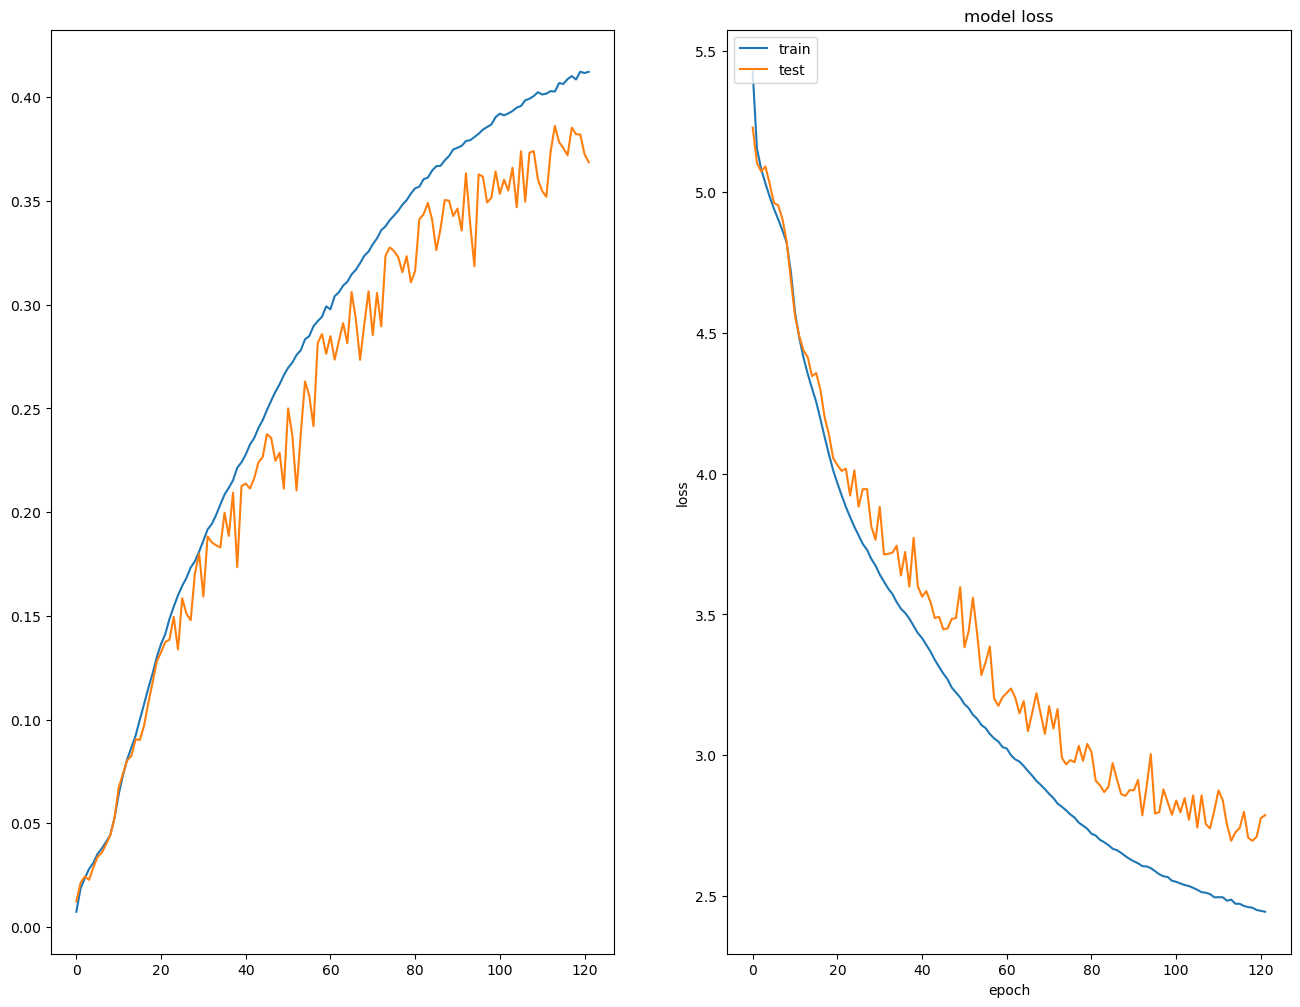

In [18]:
# summarize history for accuracy
f, (ax_acc, ax_loss) = plt.subplots(ncols=2, figsize=(16,12))

ax_acc.plot(history.history['accuracy'])
ax_acc.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for loss
ax_loss.plot(history.history['loss'])
ax_loss.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig('acc_loss-model_test-mirror-rnn.png')
plt.show()